# Multiple Instance Segmentation using Mask R-CNN architecture

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.5 MB/s eta 0:

In [2]:
# Import libraries
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch_snippets import *
from torch_snippets.inspector import inspect
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

!nvidia-smi # check if GPU is available
%matplotlib inline

Thu Mar  7 04:06:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Download, install and import some COCO training utilities from torchvision
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

from engine import train_one_epoch, evaluate
import utils
import transforms as T

  Preparing metadata (setup.py) ... done


In [4]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [5]:
# Download and extract the dataset
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar

In [5]:
# Retrieve the lists of images and annotations
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

In [7]:
# Filter out images without the classes we are interested in
classes_list = [4, 6] # Person and Table classes
annotations = []
for annotation in Tqdm(all_annots):
    r, g, _ = read(annotation, 1).transpose(2,0,1)
    if np.array([_class in np.unique(r) for _class in classes_list]).sum() == 0:
        continue
    annotations.append(annotation)

# Split the annotations dataset into training and validation sets
train_items, val_items = train_test_split(stems(annotations), random_state=4)

100%|██████████| 5000/5000 [00:32<00:00, 154.75it/s]


In [8]:
# Create a function to perform a transformation on the images
def get_transform(train):
    image_transforms = [T.PILToTensor()]
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [9]:
# Create Dataset class to fetch images and labels
class MasksDataset(Dataset):
    def __init__(self, items, transforms, n_total):
        self.items = items
        self.transforms = transforms
        self.n_total = n_total

    def __len__(self): return self.n_total

    def get_masks(self, masks_path):
        r, g, _ = read(masks_path, 1).transpose(2,0,1)
        _classes = list(set(np.unique(r)).intersection({4, 6})) # Person and Table classes

        masks = []
        labels = []
        for _class in _classes:
            non_zero = np.nonzero(r == _class)
            instances = np.unique(g[non_zero])
            for instance in instances:
                masks.append(g == instance)
                labels.append(classes_list.index(_class) + 1)
        return np.array(masks), np.array(labels)

    def __getitem__(self, idx):
        item = self.items[idx]
        image_path = f'images/training/{item}.jpg'
        masks_path = f'annotations_instance/training/{item}.png'
        masks, labels = self.get_masks(masks_path)
        masks_ids = np.arange(1, len(masks) + 1)
        image = Image.open(image_path).convert("RGB")
        masks_num = len(masks_ids)

        # Create the bounding boxes for each mask
        boxes = []
        for i in range(masks_num):
            mask_pixels = np.where(masks[i])
            xmin = np.min(mask_pixels[1])
            xmax = np.max(mask_pixels[1])
            ymin = np.min(mask_pixels[0])
            ymax = np.max(mask_pixels[0])
            if (xmax - xmin) <= 10 | (ymax - ymin) <= 10: # Add padding to small masks to avoid error
                xmax = xmin + 10
                ymax = ymin + 10
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert all targets to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((masks_num,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        # Apply the transformations
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        if image.dtype in [torch.float32, torch.uint8]:
            image = image/255.

        return image, target

    def choose(self): return self[randint(len(self))]

══════════════════════════════════════════════════════════════════

tensor([[[0.1725, 0.1765, 0.1765,  ..., 0.0824, 0.0902, 0.0941],
         [0.1804, 0.1843, 0.1843,  ..., 0.0902, 0.0941, 0.0980],
         [0.1882, 0.1922, 0.1922,  ..., 0.1020, 0.1020, 0.1020],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.5765, 0.6118, 0.6157],
         [0.9843, 0.9922, 0.9922,  ..., 0.4863, 0.5176, 0.5176],
         [0.9843, 0.9922, 0.9922,  ..., 0.4196, 0.4549, 0.4549]],

        [[0.1647, 0.1686, 0.1686,  ..., 0.0745, 0.0824, 0.0863],
         [0.1725, 0.1765, 0.1765,  ..., 0.0824, 0.0863, 0.0902],
         [0.1804, 0.1843, 0.1843,  ..., 0.0941, 0.0941, 0.0941],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.1804, 0.1843, 0.1647],
         [1.0000, 1.0000, 1.0000,  ..., 0.1216, 0.1255, 0.1059],
         [1.0000, 1.0000, 1.0000,  ..., 0.0784, 0.0784, 0.0627]],

        [[0.1765, 0.1804, 0.1804,  ..., 0.0235, 0.0314, 0.0353],
         [0.1843, 0.1882, 0.1882,  ..., 0.0314, 0.0353, 0.0392],
         [0.1922, 0.1961, 0.1961,  ..., 0.0471, 0.0471, 0.0471],
         ...,
         [0.9882, 0.9765, 0.9765,  ..., 0.1098, 0.1020, 0.0824],
         [0.9882, 0.9765, 0.9765,  ..., 0.0510, 0.0353, 0.0196],
         [0.9882, 0.9765, 0.9765,  ..., 0.0039, 0.0000, 0.0000]]])

══════════════════════════════════════════════════════════════════

dict of 6 items

tensor([[  1.,   0., 207., 457.],
        [596., 124., 659., 225.],
        [328.,  64., 395., 183.],
        [605., 100., 682., 218.],
        [144.,   0., 193.,  30.],
        [  4., 391., 178., 508.],
        [270., 254., 329., 305.],
        [332., 397., 429., 493.],
        [463., 325., 526., 421.],
        [620., 300., 683., 361.]])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

tensor([[[0, 1, 1,  ..., 0, 0, 0],
         [0, 1, 1,  ..., 0, 0, 0],
         [0, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

tensor([0])

tensor([94142.,  6363.,  7973.,  9086.,  1470., 20358.,  3009.,  9312.,  6048.,
         3843.])

... ... 1 more item(s)

══════════════════════════════════════════════════════════════════

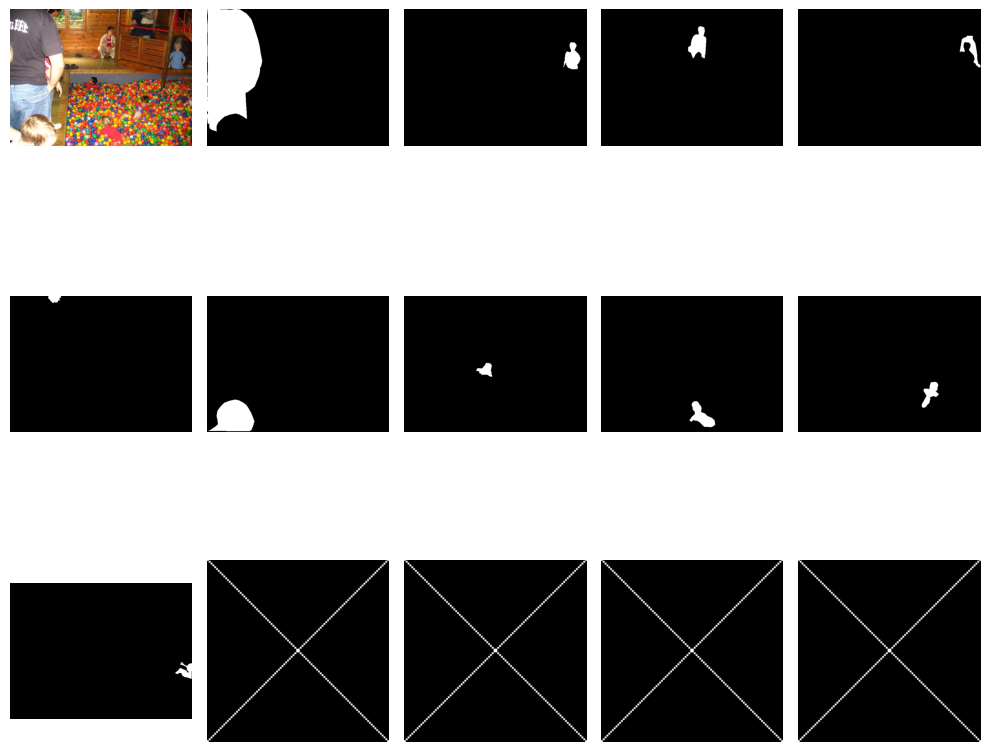

In [10]:
# Inspect a sample from the dataset
sample = MasksDataset(train_items, get_transform(train=True), n_total=100)
image, target = sample[1]
inspect(image, target)

# Plot the image and its masks
subplots([image, *target['masks']], sz=10)

In [11]:
# Create a function to load the pre-trained model
def load_model(num_classes):
    # Load Mask R-CNN (ResNet-50 backbone, pre-trained on COCO dataset)
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights)

    # Extract the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Extract the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    # Replace the pre-trained mask head
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [12]:
# Print model architecture
model = load_model(num_classes=3).to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [13]:
# Create train and validation datasets
train_ds = MasksDataset(train_items, get_transform(train=True), n_total=len(train_items))
val_ds = MasksDataset(val_items, get_transform(train=False), n_total=len(val_items))

# Create a function to retrieve the dataloaders
def load_data():
    train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
    return train_dl, val_dl

In [50]:
# Train the model
model = load_model(num_classes=3).to(device)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(trainable_params, lr=5e-3, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
train_dl, val_dl = load_data()
n_epochs = 4

history = []
for epoch in range(n_epochs):
    # Use train_one_epoch utility to train the model for one epoch and print the results every 10 iterations
    res = train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    history.append(res)
    lr_scheduler.step()
    # Use evaluate utility to evaluate the model on the validation dataset
    res = evaluate(model, val_dl, device=device)

Epoch: [0]  [  0/483]  eta: 0:05:32  lr: 0.000015  loss: 3.2824 (3.2824)  loss_classifier: 0.7918 (0.7918)  loss_box_reg: 0.3105 (0.3105)  loss_mask: 2.1259 (2.1259)  loss_objectness: 0.0420 (0.0420)  loss_rpn_box_reg: 0.0122 (0.0122)  time: 0.6879  data: 0.0455  max mem: 3968
Epoch: [0]  [ 10/483]  eta: 0:04:57  lr: 0.000119  loss: 3.2824 (3.3541)  loss_classifier: 0.7242 (0.7197)  loss_box_reg: 0.3105 (0.2806)  loss_mask: 2.1259 (2.2349)  loss_objectness: 0.0407 (0.0905)  loss_rpn_box_reg: 0.0135 (0.0285)  time: 0.6287  data: 0.0323  max mem: 3968
Epoch: [0]  [ 20/483]  eta: 0:05:02  lr: 0.000223  loss: 2.1283 (2.4846)  loss_classifier: 0.4997 (0.5420)  loss_box_reg: 0.3225 (0.3203)  loss_mask: 1.0544 (1.5308)  loss_objectness: 0.0229 (0.0617)  loss_rpn_box_reg: 0.0127 (0.0298)  time: 0.6519  data: 0.0363  max mem: 3968
Epoch: [0]  [ 30/483]  eta: 0:05:10  lr: 0.000326  loss: 1.2869 (2.0163)  loss_classifier: 0.2723 (0.4369)  loss_box_reg: 0.2548 (0.3039)  loss_mask: 0.5693 (1.1890) 

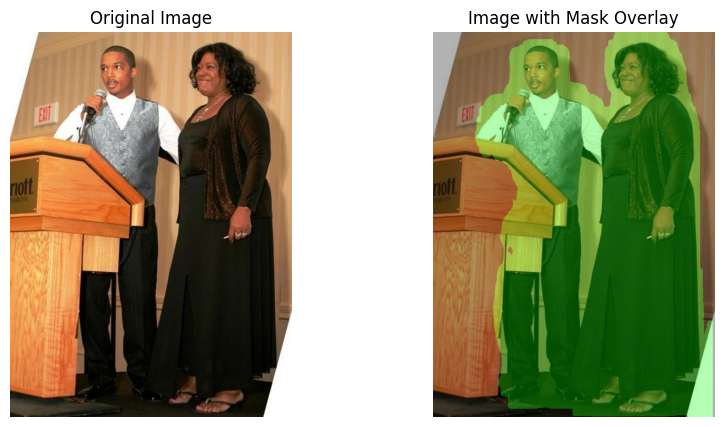

In [51]:
# Make predictions on a sample image from the validation dataset and display the masks on the image
model.eval()
image, target = val_ds[4]  # Get a sample and its target from the dataset

with torch.no_grad():
    prediction = model([image.to(device)])  # Predict
    masks = prediction[0]['masks'].mul(255).byte().cpu().numpy()
    masks_summed = np.sum(masks, axis=0)
    masks_binary = np.where(masks_summed > 0, 255, 0).astype(np.uint8)
    masks_binary_squeezed = np.squeeze(masks_binary)

# Convert the PyTorch tensor image back to a NumPy array for plotting
image_np = image.cpu().numpy().transpose(1, 2, 0)  # Rearrange the dimensions [C, H, W] -> [H, W, C]

# Assuming the image might be normalized, rescale back to [0, 255] if necessary
if np.min(image_np) < 0 or np.max(image_np) > 1:
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.axis('off')
plt.title('Original Image')

# Overlay the binary mask on the original image
# Create an RGB version of the binary mask
mask_overlay = np.zeros_like(image_np)
mask_indices = masks_binary_squeezed > 0
mask_overlay[mask_indices] = [0, 1, 0]  # Green color mask

# Display the original image with mask overlay
plt.subplot(1, 2, 2)
plt.imshow(image_np)
plt.imshow(mask_overlay, alpha=0.3)  # Use alpha to blend the mask with the image
plt.axis('off')
plt.title('Image with Mask Overlay')

plt.show()